[('Farmland', '6.23%', '1.21', '0, 255, 0'), ('Water', '5.48%', '1.06', '0, 0, 255'), ('Forest', '4.16%', '0.81', '0, 255, 255'), ('Built-Up', '80.32%', '15.60', '255, 0, 0'), ('Meadow', '3.80%', '0.74', '255, 255, 0')]


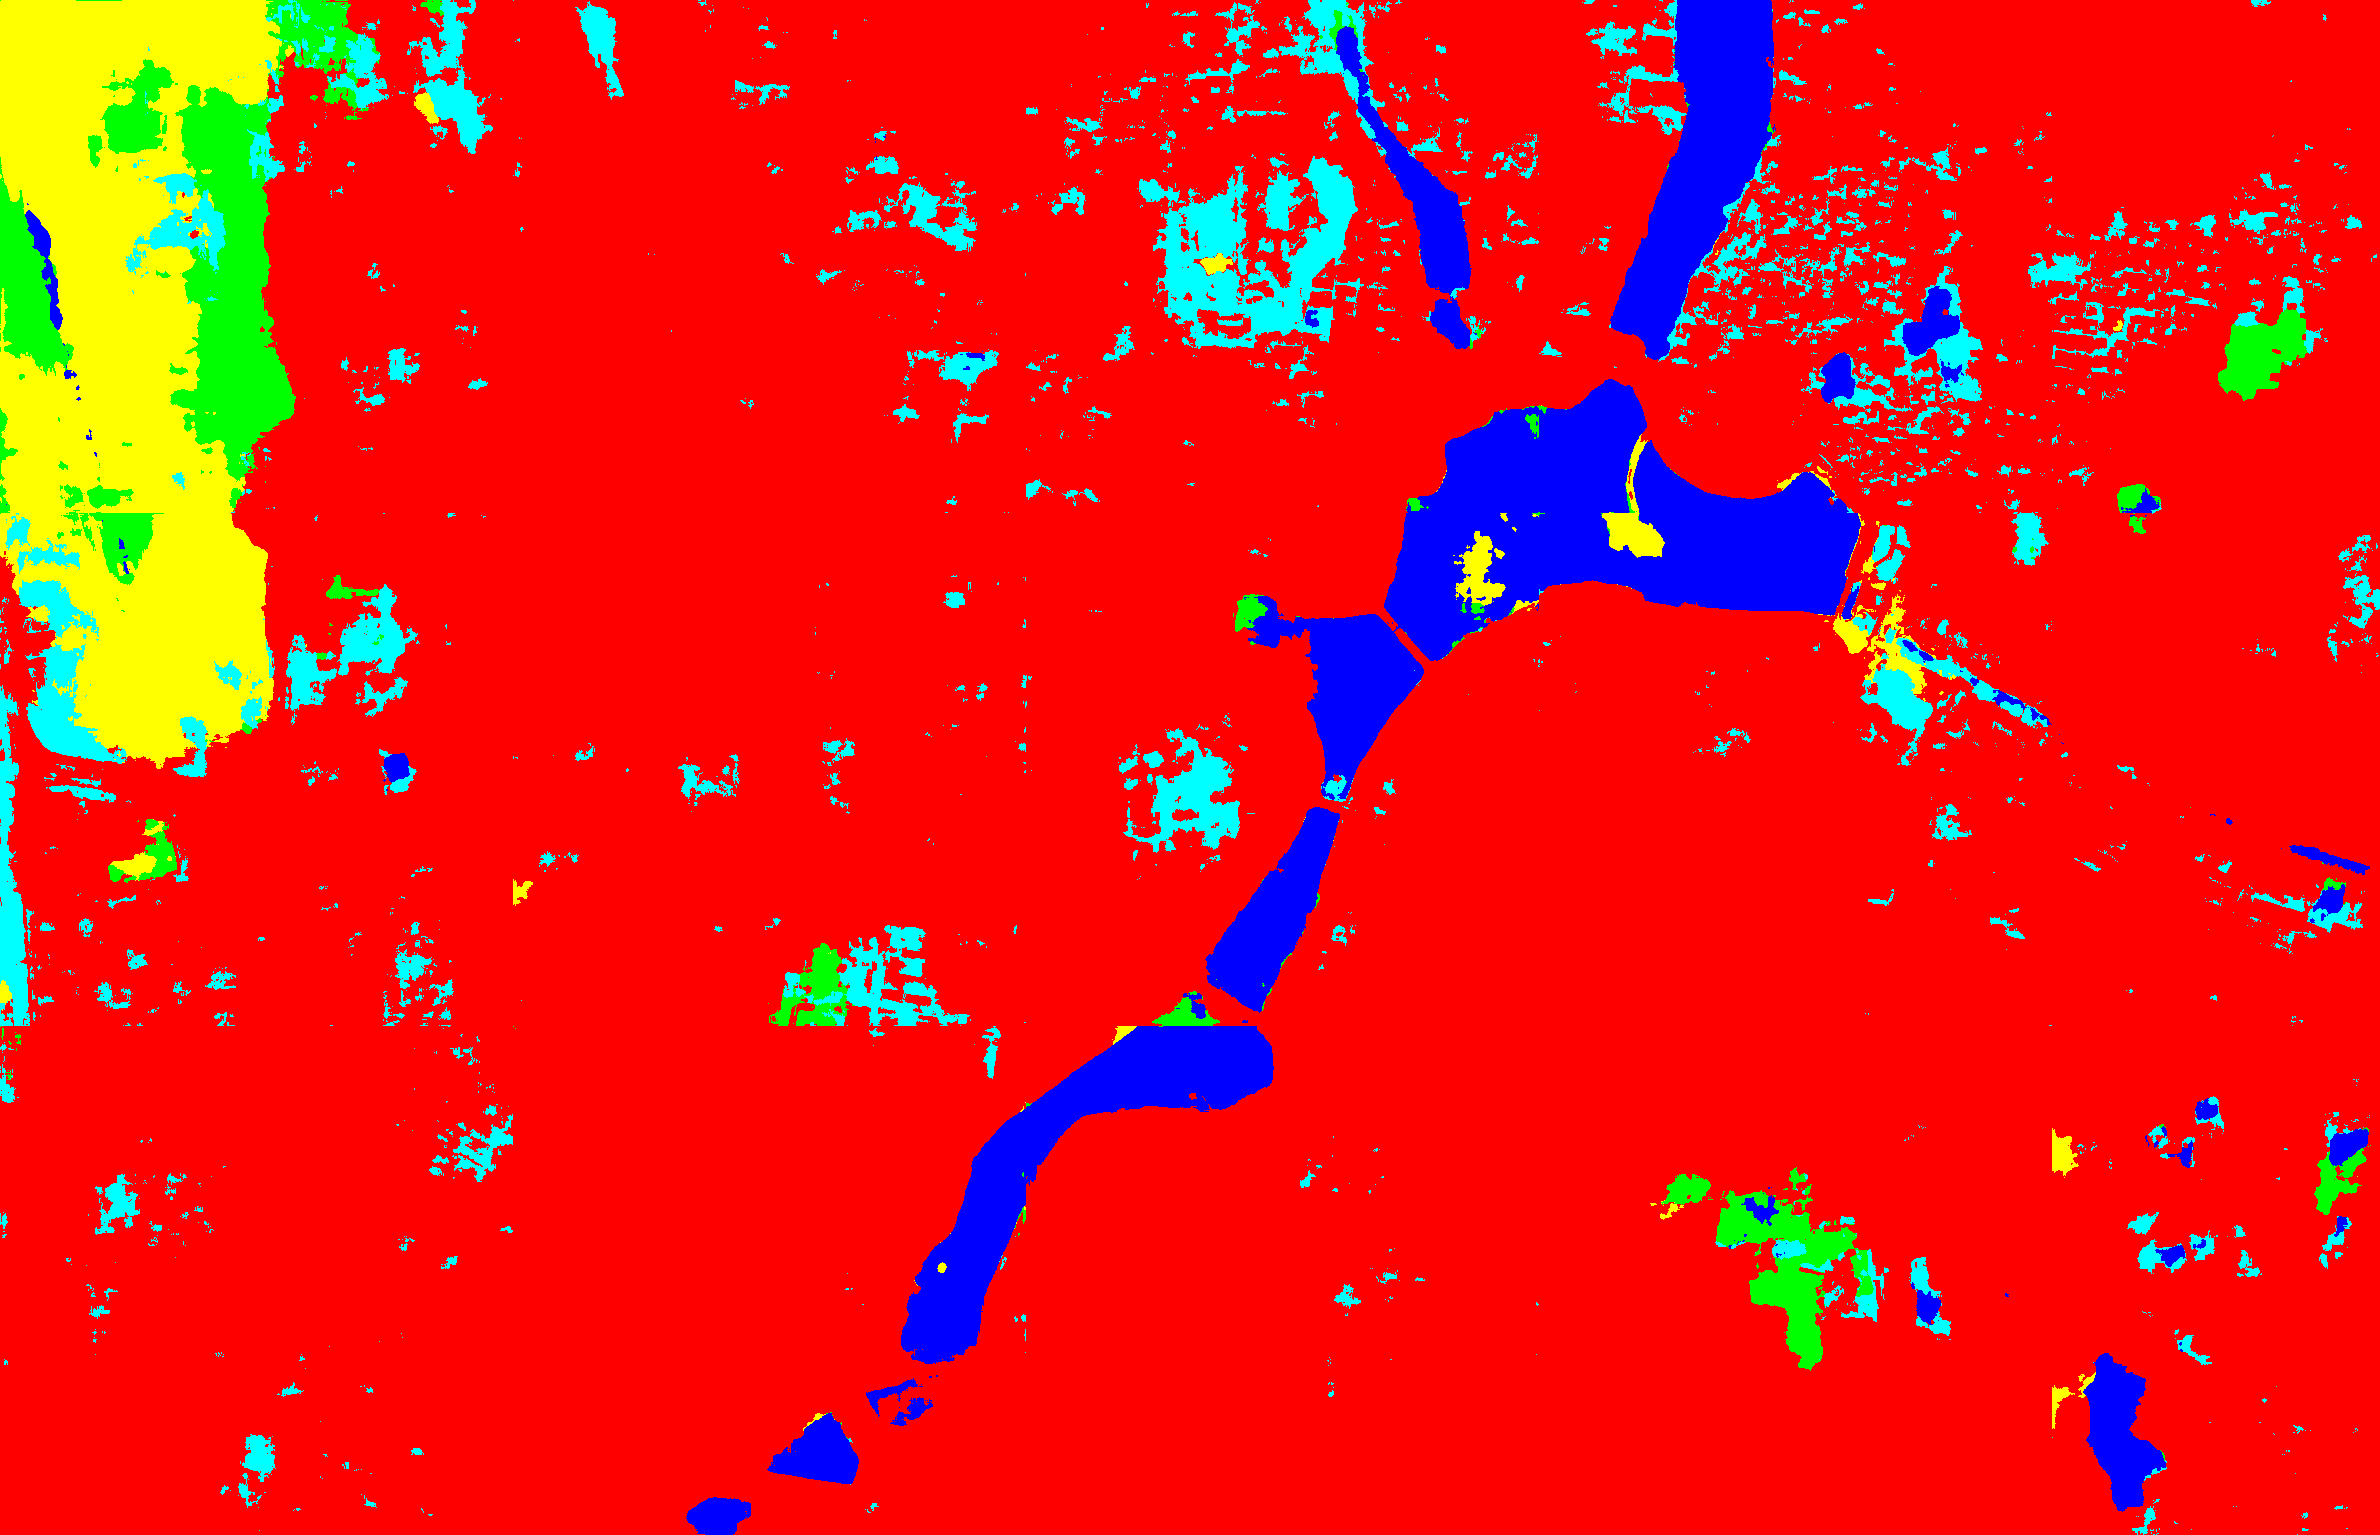

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
# from patchify import patchify, unpatchify
from torch.utils.data import Dataset, DataLoader
from UNet_LULC.UNet.unet.unet_model import UNet


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=3, n_classes=6, bilinear=False)

model.to(device)

unimatch_path = '/opt/models/exp/unet_0.pth'
checkpoint = torch.load(
    unimatch_path, map_location='cpu', weights_only=False)
new_state_dict = {}
for k, v in checkpoint['model_state_dict'].items():
    new_key = k.replace('module.', '')
    new_state_dict[new_key] = v
model.load_state_dict(new_state_dict)


def make_patches(image: np.ndarray, patch_size: int) -> tuple[np.ndarray, tuple[int, int]]:
    """
    Splits a PIL image into patches of size (patch_size, patch_size),
    zero-padding the remaining parts if needed.

    Args:
        image (PIL.Image.Image): Input image.
        patch_size (int): Size of each patch (square).

    Returns:
        numpy.ndarray: Array of patches with shape 
        (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, 3)
    """
    
    image_size = image.shape[1], image.shape[0]
    image_np = image
    h, w, c = image_np.shape

    num_patches_vertical = (h + patch_size - 1) // patch_size
    num_patches_horizontal = (w + patch_size - 1) // patch_size

    patches = np.zeros(
        (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, c),
        dtype=image_np.dtype
    )

    for i in range(num_patches_vertical):
        for j in range(num_patches_horizontal):
            y_start = i * patch_size
            x_start = j * patch_size
            patch = image_np[y_start:y_start +
                             patch_size, x_start:x_start + patch_size]

            # Handle padding if needed
            padded_patch = np.zeros(
                (patch_size, patch_size, c), dtype=image_np.dtype)
            padded_patch[:patch.shape[0], :patch.shape[1], :] = patch

            patches[i, j, 0] = padded_patch

    return patches, image_size


def unpatchify(patches: np.ndarray, original_size: tuple[int, int]) -> np.ndarray:
    """
    Reconstructs the original image from patches.

    Args:
        patches (numpy.ndarray): Array of patches with shape 
            (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, 3)
        original_height (int): Height of the original image.
        original_width (int): Width of the original image.

    Returns:
        PIL.Image.Image: Reconstructed image.
    """
    original_width, original_height = original_size
    num_patches_vertical, num_patches_horizontal, _, patch_size, _, _ = patches.shape

    # Calculate full reconstructed size with padding
    full_height = num_patches_vertical * patch_size
    full_width = num_patches_horizontal * patch_size

    # Create an empty array to hold the reconstructed (possibly padded) image
    reconstructed = np.zeros((full_height, full_width, 3), dtype=patches.dtype)

    # Place each patch back into the image
    for i in range(num_patches_vertical):
        for j in range(num_patches_horizontal):
            y_start = i * patch_size
            x_start = j * patch_size
            reconstructed[y_start:y_start + patch_size,
                          x_start:x_start + patch_size] = patches[i, j, 0]

    # Remove any padding to match the original image size
    reconstructed_cropped = reconstructed[:original_height, :original_width]

    return reconstructed_cropped


def decode_segmap(image: np.ndarray, nc=6) -> np.ndarray:
    label_colors = np.array(
        [(0, 0, 0), (0, 255, 0), (0, 0, 255),
         (0, 255, 255), (255, 0, 0), (255, 255, 0)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


class LULCDataset(Dataset):
    def __init__(self, images, transform=None):
        self.transform = transform
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        
        return image


def predict(image: np.ndarray, patch_size: int = 513) -> tuple[Image.Image, Image.Image]:
    image = image[:, :, :3]
    original_image = image
    patch_images, image_size = make_patches(image, patch_size)
    size_y, size_x, _, p_s_1, p_s_2, channels = patch_images.shape
    patch_images = patch_images.reshape(
        size_x * size_y, p_s_1, p_s_2, channels)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                                         std=[0.229, 0.224, 0.225])
    ])

    dataset = LULCDataset(
        patch_images, transform=transform)

    loader = DataLoader(
        dataset, batch_size=24, shuffle=False, num_workers=4)

    output_images = []
    count_array = np.zeros(6, dtype=np.int_)

    model.eval()
    
    with torch.no_grad():
        for batch_images in loader:
            batch_images = batch_images.to(device).to(torch.float32)

            output = model(batch_images)
            output = output.detach().max(dim=1)[1].cpu().numpy()
            unique, counter = np.unique(output, return_counts=True)
            count_temp = np.zeros(6, dtype=np.int_)

            count_temp[unique] = counter

            count_array += count_temp
            for output_item in output:
                output_item = decode_segmap(output_item)
                output_item = Image.fromarray(output_item)
                output_images.append(output_item)

    output_images = np.stack(output_images, axis=0).reshape(
        size_y, size_x, 1, p_s_1, p_s_2, channels)

    output_image = unpatchify(output_images, image_size)
    img = Image.fromarray(output_image)

    labels = ['Farmland',
              'Water', 'Forest', 'Built-Up', 'Meadow']
    colors = ['0, 255, 0', '0, 0, 255',
              '0, 255, 255', '255, 0, 0', '255, 255, 0']

    area = [f'{val * 4.92e-6:,.2f}' for val in count_array[1:]]
    max_pixel = np.sum(count_array[1:]) or 1

    count_array = [f'{val / max_pixel * 100:.2f}%' for val in count_array[1:]]
    table = list(zip(labels, list(count_array), area, colors))


    torch.cuda.empty_cache()
    print(table)

    return Image.fromarray(original_image), img, table


image = Image.open(
    'trash/input_image_123.png')
image = predict(np.asarray(image))
    
image[1]

In [1]:
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torchvision
import numpy as np
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from UNet_LULC.UNet.unet.unet_model import UNet
from PIL import Image

def make_patches(image: np.ndarray, patch_size: int) -> tuple[np.ndarray, tuple[int, int]]:
    """
    Splits a PIL image into patches of size (patch_size, patch_size),
    zero-padding the remaining parts if needed.

    Args:
        image (PIL.Image.Image): Input image.
        patch_size (int): Size of each patch (square).

    Returns:
        numpy.ndarray: Array of patches with shape 
        (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, 3)
    """
    
    image_size = image.shape[1], image.shape[0]
    image_np = image
    h, w, c = image_np.shape

    num_patches_vertical = (h + patch_size - 1) // patch_size
    num_patches_horizontal = (w + patch_size - 1) // patch_size

    patches = np.zeros(
        (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, c),
        dtype=image_np.dtype
    )

    for i in range(num_patches_vertical):
        for j in range(num_patches_horizontal):
            y_start = i * patch_size
            x_start = j * patch_size
            patch = image_np[y_start:y_start +
                             patch_size, x_start:x_start + patch_size]

            # Handle padding if needed
            padded_patch = np.zeros(
                (patch_size, patch_size, c), dtype=image_np.dtype)
            padded_patch[:patch.shape[0], :patch.shape[1], :] = patch

            patches[i, j, 0] = padded_patch

    return patches, image_size


def unpatchify(patches: np.ndarray, original_size: tuple[int, int]) -> np.ndarray:
    """
    Reconstructs the original image from patches.

    Args:
        patches (numpy.ndarray): Array of patches with shape 
            (num_patches_vertical, num_patches_horizontal, 1, patch_size, patch_size, 3)
        original_height (int): Height of the original image.
        original_width (int): Width of the original image.

    Returns:
        PIL.Image.Image: Reconstructed image.
    """
    original_width, original_height = original_size
    num_patches_vertical, num_patches_horizontal, _, patch_size, _, _ = patches.shape

    # Calculate full reconstructed size with padding
    full_height = num_patches_vertical * patch_size
    full_width = num_patches_horizontal * patch_size

    # Create an empty array to hold the reconstructed (possibly padded) image
    reconstructed = np.zeros((full_height, full_width, 3), dtype=patches.dtype)

    # Place each patch back into the image
    for i in range(num_patches_vertical):
        for j in range(num_patches_horizontal):
            y_start = i * patch_size
            x_start = j * patch_size
            reconstructed[y_start:y_start + patch_size,
                          x_start:x_start + patch_size] = patches[i, j, 0]

    # Remove any padding to match the original image size
    reconstructed_cropped = reconstructed[:original_height, :original_width]

    return reconstructed_cropped


def decode_segmap(image: np.ndarray, nc=6) -> np.ndarray:
    label_colors = np.array(
        [(0, 0, 0), (0, 255, 0), (0, 0, 255),
         (0, 255, 255), (255, 0, 0), (255, 255, 0)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [2]:
# import os
# import torch
# import torch.distributed as dist
# import torch.multiprocessing as mp
# import torchvision
# import numpy as np
# import torch.nn as nn
# from torch.nn.parallel import DistributedDataParallel as DDP
# from torch.utils.data import Dataset, DataLoader, DistributedSampler
# from UNet_LULC.UNet.unet.unet_model import UNet
# from PIL import Image

# -------------------------------
# Distributed Training Initialization
# -------------------------------
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'  # Choose an open port

    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)

# -------------------------------
# Load Model on Multiple GPUs
# -------------------------------
def load_model(rank):
    model = UNet(n_channels=3, n_classes=6, bilinear=False).to(rank)
    model = DDP(model, device_ids=[rank])

    unimatch_path = '/opt/models/exp/unet_0.pth'
    checkpoint = torch.load(unimatch_path, map_location='cpu')

    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint['model_state_dict'].items()}
    model.load_state_dict(new_state_dict)
    return model

# -------------------------------
# Custom Dataset Class
# -------------------------------
class LULCDataset(Dataset):
    def __init__(self, images, transform=None):
        self.transform = transform
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        return image

# -------------------------------
# Prediction Function
# -------------------------------
def predict(rank, world_size, image: np.ndarray, patch_size: int = 513):
    setup(rank, world_size)
    model = load_model(rank)
    model.eval()

    image = image[:, :, :3]
    original_image = image
    patch_images, image_size = make_patches(image, patch_size)
    
    size_y, size_x, _, p_s_1, p_s_2, channels = patch_images.shape
    patch_images = patch_images.reshape(size_x * size_y, p_s_1, p_s_2, channels)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = LULCDataset(patch_images, transform=transform)
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=False)

    loader = DataLoader(dataset, batch_size=24, shuffle=False, num_workers=4, sampler=sampler)

    output_images = []
    count_array = np.zeros(6, dtype=np.int_)

    with torch.no_grad():
        for batch_images in loader:
            batch_images = batch_images.to(rank).to(torch.float32)
            output = model(batch_images)
            output = output.detach().max(dim=1)[1].cpu().numpy()

            unique, counter = np.unique(output, return_counts=True)
            count_temp = np.zeros(6, dtype=np.int_)
            count_temp[unique] = counter
            count_array += count_temp

            for output_item in output:
                output_item = decode_segmap(output_item)
                output_item = Image.fromarray(output_item)
                output_images.append(output_item)

    output_images = np.stack(output_images, axis=0).reshape(size_y, size_x, 1, p_s_1, p_s_2, channels)
    output_image = unpatchify(output_images, image_size)
    img = Image.fromarray(output_image)

    labels = ['Farmland', 'Water', 'Forest', 'Built-Up', 'Meadow']
    colors = ['0, 255, 0', '0, 0, 255', '0, 255, 255', '255, 0, 0', '255, 255, 0']
    
    area = [f'{val * 4.92e-6:,.2f}' for val in count_array[1:]]
    max_pixel = np.sum(count_array[1:]) or 1
    count_array = [f'{val / max_pixel * 100:.2f}%' for val in count_array[1:]]
    table = list(zip(labels, count_array, area, colors))

    torch.cuda.empty_cache()
    print(table)

    dist.destroy_process_group()  # Clean up DDP

    return Image.fromarray(original_image), img, table

# -------------------------------
# Main Function to Launch Multi-GPU Inference
# -------------------------------
def main():
    world_size = torch.cuda.device_count()
    if world_size < 2:
        raise RuntimeError("At least 2 GPUs are required for DDP")

    # image = np.random.randint(0, 255, (1024, 1024, 3), dtype=np.uint8)  # Example image
    
    image = Image.open('trash/input_image_123.png')
    # image = predict(np.asarray(image))
    mp.spawn(predict, args=(world_size, np.asarray(image)), nprocs=world_size, join=True)

if __name__ == "__main__":
    world_size = torch.cuda.device_count()
    if world_size < 2:
        raise RuntimeError("At least 2 GPUs are required for DDP")

    # image = np.random.randint(0, 255, (1024, 1024, 3), dtype=np.uint8)  # Example image
    
    image = Image.open('trash/input_image_123.png')
    # image = predict(np.asarray(image))
    mp.spawn(predict, args=(world_size, np.asarray(image)), nprocs=world_size, join=True)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/skeptic/miniconda3/envs/sat-segment/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/skeptic/miniconda3/envs/sat-segment/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'predict' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 